In [1]:
!pip install -q transformers datasets evaluate rouge_score accelerate matplotlib
!pip install -q -U torch

from google.colab import drive
import os

drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 19.4 MB/s eta 0:00:00
   ━━━

In [3]:
import zipfile
import json
import shutil

# --- CẤU HÌNH ĐƯỜNG DẪN (SỬA DÒNG NÀY) ---
# Thư mục trên Drive mới chứa file zip model (và file trainer_state.json nếu có)
drive_folder = "/content/drive/MyDrive"
zip_filename = "/content/drive/MyDrive/final_vit5_model-20251208T140830Z-1-001.zip"

# --- KHÔNG CẦN SỬA DƯỚI NÀY ---
zip_path = os.path.join(drive_folder, zip_filename)
extract_path = "/content/loaded_model"
MODEL_CHECKPOINT = None
old_log_file = None

# 1. Giải nén Model
if os.path.exists(zip_path):
    print(f"📦 Đang giải nén model từ {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Tìm đường dẫn thực sự chứa config.json
    for root, dirs, files in os.walk(extract_path):
        if "config.json" in files:
            MODEL_CHECKPOINT = root
            break
    print(f"✅ Model đã sẵn sàng tại: {MODEL_CHECKPOINT}")
else:
    print(f"❌ LỖI: Không tìm thấy file zip tại {zip_path}")

# 2. Tìm file Log cũ (trainer_state.json) để vẽ biểu đồ
# Ưu tiên 1: Tìm trong thư mục Drive (nếu bạn đã copy file json lẻ sang)
potential_log = os.path.join(drive_folder, "trainer_state.json")
if os.path.exists(potential_log):
    old_log_file = potential_log
    print(f"📜 Đã tìm thấy log cũ trên Drive: {old_log_file}")
# Ưu tiên 2: Tìm trong folder vừa giải nén
elif MODEL_CHECKPOINT:
    potential_log_in_zip = os.path.join(MODEL_CHECKPOINT, "trainer_state.json")
    if os.path.exists(potential_log_in_zip):
        old_log_file = potential_log_in_zip
        print(f"📜 Đã tìm thấy log cũ trong file zip.")

if not old_log_file:
    print("⚠️ Không có file trainer_state.json -> Biểu đồ sẽ chỉ hiện Phase 2 (không nối liền).")

📦 Đang giải nén model từ /content/drive/MyDrive/final_vit5_model-20251208T140830Z-1-001.zip...
✅ Model đã sẵn sàng tại: /content/loaded_model/final_vit5_model
📜 Đã tìm thấy log cũ trên Drive: /content/drive/MyDrive/trainer_state.json


In [4]:
import torch
import numpy as np
from pathlib import Path
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments,
    Seq2SeqTrainer, EarlyStoppingCallback
)
import evaluate

# --- CONFIG ---
DATASET_NAME = "8Opt/vietnamese-summarization-dataset-0001"
DRIVE_ROOT = Path("/content/drive/MyDrive/train-vit5-abstractive")
NEW_CHECKPOINT_DIR = DRIVE_ROOT /"checkpoints_vit5_phase2"
FINAL_SAVE_PATH = DRIVE_ROOT / "final_vit5_model_phase2"

# Tham số Training
MAX_SOURCE_LEN = 1280
MAX_TARGET_LEN = 256
BATCH_SIZE = 2
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3  # Train thêm 3 epoch nữa

device = "cuda" if torch.cuda.is_available() else "cpu"

Tải Dataset

In [5]:
raw_datasets = load_dataset(DATASET_NAME)

def normalize_columns(dataset):
    mapping = {"document": "input_text", "summary": "target_text", "content": "input_text", "abstract": "target_text"}
    for old, new in mapping.items():
        if old in dataset.column_names: dataset = dataset.rename_column(old, new)
    return dataset

for split in raw_datasets.keys():
    raw_datasets[split] = normalize_columns(raw_datasets[split])

raw_datasets = raw_datasets.filter(lambda x: x['input_text'] is not None and x['target_text'] is not None)
print("Data loaded.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/30.2M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/3.89M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15620 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1952 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1953 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15620 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1952 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1953 [00:00<?, ? examples/s]

Data loaded.


Tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def preprocess_function(examples):
    inputs = [str(doc) for doc in examples["input_text"]]
    targets = [str(sum) for sum in examples["target_text"]]
    model_inputs = tokenizer(inputs, max_length=MAX_SOURCE_LEN, truncation=True)
    labels = tokenizer(text_target=targets, max_length=MAX_TARGET_LEN, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True, remove_columns=raw_datasets["train"].column_names)

Map:   0%|          | 0/15620 [00:00<?, ? examples/s]

Map:   0%|          | 0/1952 [00:00<?, ? examples/s]

Map:   0%|          | 0/1953 [00:00<?, ? examples/s]

Metric & Data Collator

In [14]:
rouge = evaluate.load("rouge")

import nltk
# Tải bộ tách câu của NLTK
nltk.download("punkt")
nltk.download("punkt_tab")

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if isinstance(predictions, tuple): predictions = predictions[0]

    # 1. Fix lỗi Overflow/Token rác (Giữ nguyên phần này vì nó tốt)
    predictions = np.array(predictions)
    predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
    vocab_size = len(tokenizer)
    predictions = np.where((predictions >= vocab_size) | (predictions < 0), tokenizer.pad_token_id, predictions)

    # 2. Decode
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # 3. --- SỬA LẠI PHẦN TÁCH CÂU (QUAN TRỌNG) ---
    # Thay vì .split() (tách từ), ta dùng sent_tokenize (tách câu)
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    # 4. Tính điểm
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 4) for k, v in result.items()}

# Load Model
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT).to(device)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, label_pad_token_id=-100)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Tạo tập Eval nhỏ

In [9]:
eval_subset = tokenized_datasets["validation" if "validation" in tokenized_datasets else "test"]
if len(eval_subset) > 200:
    eval_subset = eval_subset.shuffle(seed=42).select(range(200))
    print("Đã tạo tập eval rút gọn 200 mẫu.")

Đã tạo tập eval rút gọn 200 mẫu.


Training

In [15]:
training_args = Seq2SeqTrainingArguments(
    output_dir=str(NEW_CHECKPOINT_DIR),
    overwrite_output_dir=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=2,
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_EPOCHS,
    fp16=True,
    per_device_eval_batch_size=1,  # Chống OOM
    eval_accumulation_steps=1,
    predict_with_generate=True,
    generation_max_length=128,
    logging_steps=100,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=eval_subset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("Bắt đầu Train...")
trainer.train()

/tmp/ipython-input-198367944.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Bắt đầu Train...


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.138000,1.222829,74.676100,44.130500,46.116500,68.551300
2,1.143100,1.152349,75.653100,46.192700,48.117700,69.804100
3,1.038500,1.136958,75.921800,47.080200,48.705900,70.202900


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=11715, training_loss=1.1445034960829392, metrics={'train_runtime': 8570.6691, 'train_samples_per_second': 5.467, 'train_steps_per_second': 1.367, 'total_flos': 3.78898832738304e+16, 'train_loss': 1.1445034960829392, 'epoch': 3.0})

Lưu model

In [16]:
# --- LƯU MODEL SAU KHI TRAIN XONG ---
print(f"💾 Đang lưu model vào: {FINAL_SAVE_PATH}")

# Lưu model và tokenizer
trainer.save_model(str(FINAL_SAVE_PATH))
tokenizer.save_pretrained(str(FINAL_SAVE_PATH))

# Lưu luôn trạng thái trainer (để sau này muốn vẽ lại biểu đồ thì có dữ liệu)
trainer.save_state()

print("✅ Đã lưu thành công! Bạn có thể dùng model này để chạy thực tế.")

💾 Đang lưu model vào: /content/drive/MyDrive/train-vit5-abstractive/final_vit5_model_phase2
✅ Đã lưu thành công! Bạn có thể dùng model này để chạy thực tế.


Visualize Loss

✅ Đã đọc log từ: /content/drive/MyDrive/trainer_state.json
🔍 Đang tìm log trong: /content/drive/MyDrive/train-vit5-abstractive/checkpoints_vit5_phase2
📂 Tìm thấy file log mới nhất: /content/drive/MyDrive/train-vit5-abstractive/checkpoints_vit5_phase2/checkpoint-11715/trainer_state.json
✅ Đã đọc log từ: /content/drive/MyDrive/train-vit5-abstractive/checkpoints_vit5_phase2/checkpoint-11715/trainer_state.json


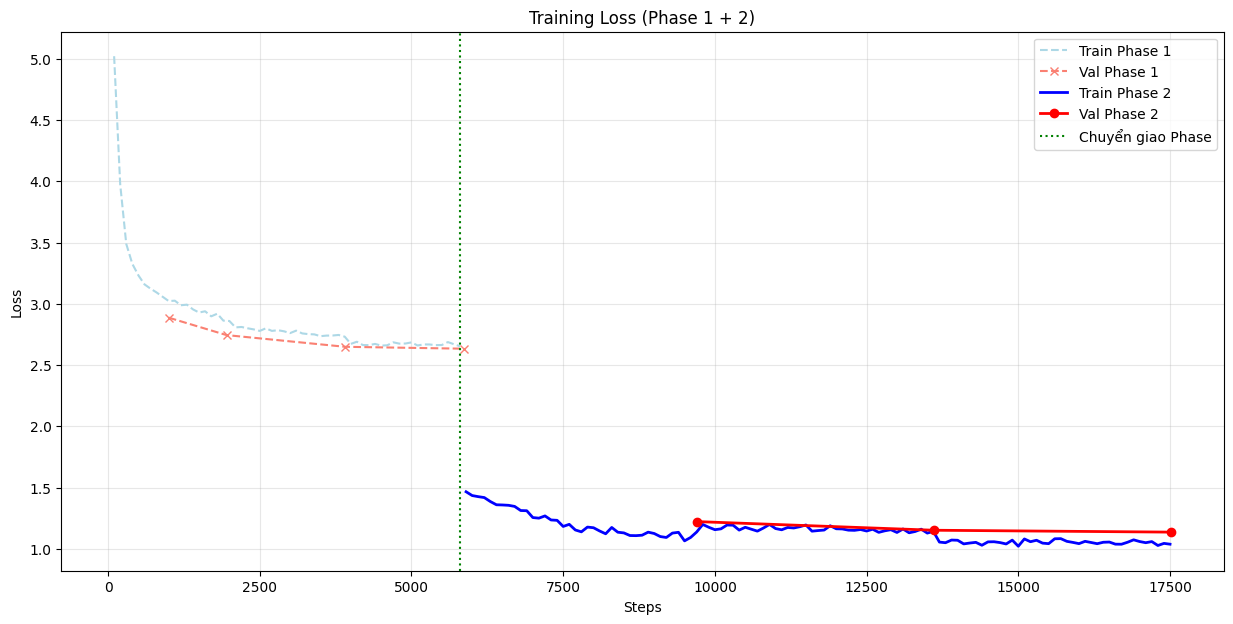

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import glob

# --- CẤU HÌNH ĐƯỜNG DẪN (Đã sửa theo ảnh của bạn) ---

# 1. Đường dẫn file log cũ (Phase 1) - File bạn up lẻ ở ngoài
PHASE1_LOG_PATH = "/content/drive/MyDrive/trainer_state.json"

# 2. Đường dẫn thư mục checkpoints Phase 2 (Sửa theo ảnh image_ea42ef.png)
# Lưu ý: Thay đổi 'do-an-tot-nghiep' thành 'train-vit5-abstractive'
PHASE2_CHECKPOINT_DIR = "/content/drive/MyDrive/train-vit5-abstractive/checkpoints_vit5_phase2"

# --- HÀM TÌM & ĐỌC LOG ---
def load_log_file(path):
    if os.path.exists(path):
        try:
            with open(path, 'r') as f:
                data = json.load(f)
                print(f"✅ Đã đọc log từ: {path}")
                return pd.DataFrame(data['log_history'])
        except Exception as e:
            print(f"⚠️ Lỗi đọc file {path}: {e}")
    return pd.DataFrame()

def find_phase2_log():
    print(f"🔍 Đang tìm log trong: {PHASE2_CHECKPOINT_DIR}")
    # Tìm file trong các thư mục con checkpoint-*
    search_pattern = os.path.join(PHASE2_CHECKPOINT_DIR, "checkpoint-*", "trainer_state.json")
    files = glob.glob(search_pattern)

    if files:
        # Lấy file mới nhất
        latest_file = max(files, key=os.path.getmtime)
        print(f"📂 Tìm thấy file log mới nhất: {latest_file}")
        return load_log_file(latest_file)

    print("❌ Không tìm thấy file log nào. Hãy kiểm tra lại đường dẫn!")
    return pd.DataFrame()

# --- CHẠY CHƯƠNG TRÌNH ---
history_phase1 = load_log_file(PHASE1_LOG_PATH)
history_phase2 = find_phase2_log()

def clean_log(df):
    if df.empty: return pd.DataFrame(), pd.DataFrame()
    t = df[df['loss'].notna()][['step', 'loss']].copy()
    e = df[df['eval_loss'].notna()][['step', 'eval_loss']].copy()
    return t, e

t1, e1 = clean_log(history_phase1)
t2, e2 = clean_log(history_phase2)

# Nối bước
offset = 0
if not t1.empty: offset = t1['step'].max()

if not t2.empty: t2['step'] += offset
if not e2.empty: e2['step'] += offset

# Vẽ biểu đồ
if t1.empty and t2.empty:
    print("⚠️ Không có dữ liệu để vẽ.")
else:
    plt.figure(figsize=(15, 7))
    if not t1.empty: plt.plot(t1['step'], t1['loss'], label='Train Phase 1', color='lightblue', linestyle='--')
    if not e1.empty: plt.plot(e1['step'], e1['eval_loss'], label='Val Phase 1', color='salmon', marker='x', linestyle='--')

    if not t2.empty: plt.plot(t2['step'], t2['loss'], label='Train Phase 2', color='blue', linewidth=2)
    if not e2.empty: plt.plot(e2['step'], e2['eval_loss'], label='Val Phase 2', color='red', marker='o', linewidth=2)

    if offset > 0: plt.axvline(x=offset, color='green', linestyle=':', label='Chuyển giao Phase')

    plt.xlabel('Steps'); plt.ylabel('Loss'); plt.title('Training Loss (Phase 1 + 2)'); plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

Visualize ROUGE

Đang đánh giá ROUGE trên 100 mẫu test ngẫu nhiên...


  0%|          | 0/100 [00:00<?, ?it/s]


📊 KẾT QUẢ ROUGE SCORE:
{'rouge1': np.float64(78.3), 'rouge2': np.float64(48.52), 'rougeL': np.float64(49.03), 'rougeLsum': np.float64(78.3)}


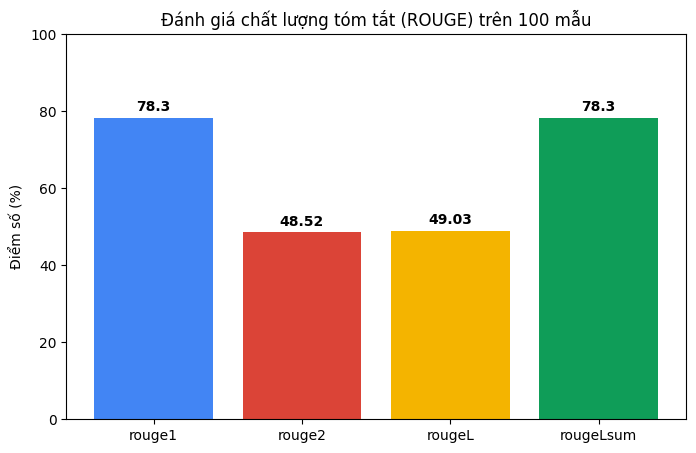

In [18]:
import nltk
import numpy as np
# Cài đặt bộ tách câu
nltk.download("punkt")
nltk.download("punkt_tab")

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if isinstance(predictions, tuple): predictions = predictions[0]

    # 1. Lọc token rác (Giữ nguyên phần này)
    predictions = np.array(predictions)
    predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
    vocab_size = len(tokenizer)
    predictions = np.where((predictions >= vocab_size) | (predictions < 0), tokenizer.pad_token_id, predictions)

    # 2. Decode từ ID sang chữ
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # 3. --- SỬA LỖI TẠI ĐÂY ---
    # Dùng nltk.sent_tokenize để tách câu (thay vì split() tách từ)
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    # 4. Tính điểm
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 4) for k, v in result.items()}

In [19]:
from transformers import pipeline
import torch

# --- CẤU HÌNH ---
# Đường dẫn đến model vừa lưu (Final Model)
# Nếu bạn vừa chạy xong cell trên thì dùng luôn biến FINAL_SAVE_PATH
# Nếu mở lại notebook mới thì điền đường dẫn cụ thể, ví dụ:
# model_path = "/content/drive/MyDrive/do-an-tot-nghiep/artifacts_03/final_vit5_model_phase2"
model_path = str(FINAL_SAVE_PATH)

device = 0 if torch.cuda.is_available() else -1

print(f"⏳ Đang load model từ: {model_path}")
summarizer = pipeline("summarization", model=model_path, tokenizer=model_path, device=device)
print("✅ Load model thành công! Sẵn sàng tóm tắt.\n")

# --- HÀM TÓM TẮT ---
def run_summarization(text):
    print("-" * 50)
    print("VĂN BẢN GỐC:")
    print(text)
    print("-" * 50)

    # Sinh tóm tắt
    # Bạn có thể chỉnh các tham số sau để kết quả hay hơn:
    # - max_length: Độ dài tối đa của tóm tắt
    # - min_length: Độ dài tối thiểu
    # - repetition_penalty: Phạt lặp từ (càng cao càng ít lặp, thường để 2.5)
    # - num_beams: Số luồng tìm kiếm (cao thì chính xác hơn nhưng chậm hơn)
    outputs = summarizer(
        text,
        max_length=128,
        min_length=20,
        num_beams=4,
        repetition_penalty=2.5,
        no_repeat_ngram_size=3,
        early_stopping=True
    )

    print("TÓM TẮT CỦA AI:")
    print(outputs[0]['summary_text'])
    print("-" * 50)

# --- NHẬP VĂN BẢN CẦN TEST VÀO ĐÂY ---
sample_text = """
Ngày 20/10, tại Hà Nội, Bộ Công Thương tổ chức Lễ công bố các doanh nghiệp có sản phẩm đạt Thương hiệu quốc gia Việt Nam năm 2022.
Đây là chương trình xúc tiến thương mại đặc thù, dài hạn và duy nhất của Chính phủ nhằm xây dựng, phát triển thương hiệu quốc gia
thông qua thương hiệu sản phẩm. Việc lựa chọn các cây thương hiệu đạt Thương hiệu quốc gia Việt Nam được tiến hành định kỳ 2 năm một lần.
Năm 2022, dù trong bối cảnh tình hình kinh tế thế giới và trong nước gặp nhiều khó khăn, thách thức, kỳ xét chọn Thương hiệu quốc gia
lần thứ 8 tiếp tục thu hút được sự quan tâm tham gia của trên 1.000 doanh nghiệp thuộc các ngành nghề lĩnh vực khác nhau trên cả nước.
"""

# Chạy thử
run_summarization(sample_text)

⏳ Đang load model từ: /content/drive/MyDrive/train-vit5-abstractive/final_vit5_model_phase2


Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


✅ Load model thành công! Sẵn sàng tóm tắt.

--------------------------------------------------
VĂN BẢN GỐC:

Ngày 20/10, tại Hà Nội, Bộ Công Thương tổ chức Lễ công bố các doanh nghiệp có sản phẩm đạt Thương hiệu quốc gia Việt Nam năm 2022. 
Đây là chương trình xúc tiến thương mại đặc thù, dài hạn và duy nhất của Chính phủ nhằm xây dựng, phát triển thương hiệu quốc gia 
thông qua thương hiệu sản phẩm. Việc lựa chọn các cây thương hiệu đạt Thương hiệu quốc gia Việt Nam được tiến hành định kỳ 2 năm một lần. 
Năm 2022, dù trong bối cảnh tình hình kinh tế thế giới và trong nước gặp nhiều khó khăn, thách thức, kỳ xét chọn Thương hiệu quốc gia 
lần thứ 8 tiếp tục thu hút được sự quan tâm tham gia của trên 1.000 doanh nghiệp thuộc các ngành nghề lĩnh vực khác nhau trên cả nước.

--------------------------------------------------
TÓM TẮT CỦA AI:
Bộ Công Thương đã tổ chức Lễ công bố các doanh nghiệp đạt Thương hiệu quốc gia Việt Nam năm 2022. Đây là chương trình xúc tiến thương mại đặc biệt, tập